# Uvod

Klasifikacija planeta i satelita Sunčevog sistema, čime će se baviti ovaj projekat, je zadatak koji nalazi svoju primenu u oblastima astronomije i istraživanja svemira. Cilj projekta je da se, koristeći napredne tehnike obrade slika i mašinskog učenja, predstavi model koji će biti sposoban da prepozna i razlikuje prvo planete, a zatim i njihove prirodne satelite na osnovu njihovih fotografija.  

Isti model će biti primenjen za obe klasifikacije. 

## Planete

Sunčev sistem se sastoji od 8 planeta, koji ujedno predstavljaju i klase koje će model predviđati:  
Merkur, Venera, Zemlja, Mars, Jupiter, Saturn, Uran i Neptun.  

Baza slika korišćena za njihovu klasifikaciju može se pronaći na sledećem linku:  
https://www.kaggle.com/datasets/emirhanai/planets-and-moons-dataset-ai-in-space?resource=download

Svaka planeta ima oko 150 fotografija, što čini osnovni skup za dalju analizu. 

U ovom delu projekta, biće prikazana dva načina za učitavanje lične baze podataka, jedan preko keras.utils biblioteke, a drugi preko klase ImageDataGenerator.  
Razlika između ova dva pristupa je što prvi učitava neizmenjene slike, dok korišćenje drugog podrazumeva proširenje gotovog skupa podataka preko augmentacije slika koristeći nasumično uvećanje, rotiranje, sečenje i okretanje fotografija, što doprinosi većoj raznolikosti podataka i povećanje sposobnosti generalizacije modela. 

##### Učitavanje potrebnih biblioteka

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib

2024-02-29 12:22:23.071054: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-29 12:22:23.103879: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 12:22:23.103905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 12:22:23.104884: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-29 12:22:23.109779: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-29 12:22:23.110185: I tensorflow/core/platform/cpu_feature_guard.cc:1

##### Deklaracija korenog direktorijuma i klasa

In [2]:
data_dir = pathlib.Path('planete')
planete = ['Merkur', 'Venera', 'Zemlja', 'Mars', 'Jupiter', 'Saturn', 'Uran', 'Neptun']

##### Parametri za konvolutivne mreže

Bitni parametri za treniranje modela su broj uzoraka po grupi (batch size) i veličina slike.  
Broj uzoraka po grupi je broj slika koji će se koristiti u jednoj iteraciji treniranja modela. Veći batch_size može ubrzati proces učenja, ali i zauzeti više memorije, dok manji može pružiti stabilniji proces učenja.  
Što se tiče veličine slike, konvolutivne mreže očekuju ulazne slike fiksne veličine, jer su dizajnirani da obrađuju matrice piksela određenih dimenzija. Postavljanjem visine i širine slike, definišu se dimenzije ulaznih slika koje će se koristiti za treniranje. Ove dimenzije moraju odgovarati ulaznom sloju modela.

In [3]:
batch_size = 32
visina_slike = 256
sirina_slike = 256

#### Učitavanje pomoću keras.utils biblioteke

Korišćenjem funkcije **tf.keras.utils.image_dataset_from_directory** neće se izvršiti nikakve izmene nad skupom podataka. Ona jednostavno učitava slike i kreira skup podataka koji se može koristiti za treniranje, testiranje i validaciju modela.  
Jedini vid preprocesiranja je normalizacija vrednosti piksela - prebacivanje na opseg vrednosti [0,1] - što znači da će gradijenti koji se koriste za ažuriranje težina biti manji i stabilniji, što može dovesti do bržeg i stabilnijeg učenja.

U tensorflow dokumentaciji (https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) se može naći argumenti koje prima ova funkcija, od kojih su bitniji:
- directory - direktorijum u kom se nalaze slike
- class_names - eksplicitna lista imena klasa. Ukoliko se ne navede, imena klasa odgovaraju imenima poddirektorijuma
- batch_size - broj uzoraka po grupi
- image_size - veličina slike
- validation_split - mora biti jednak za trening i validacioni skup. Govori koji procenat podataka se čuva za validacioni skup
- subset - podskup podataka koji vraća funkcija. Može uzimati vrednost 'training', 'validation' ili 'both'.
- seed - opciono 'seme' za nasumično mešanje podataka. Koristi se da bi se osiguralo da se pri svakom pokretanju programa podaci mešaju na isti način. Mora biti isti za trening i validacioni skup.

Može se primetiti da ovaj vid učitavanja podataka ne daje test skup, već samo validacioni.  
Ovo se može prevazići tako što se izvrši dalja podela validacionog skupa - na primer, 10% za validaciju i 20% za test. 

In [4]:
# Skup podataka za treniranje
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(visina_slike, sirina_slike),
  batch_size=batch_size)

# Skup podataka za validaciju
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(visina_slike, sirina_slike),
  batch_size=batch_size)

# Normalizacija
norm = tf.keras.layers.Rescaling(1./255)



Found 1192 files belonging to 8 classes.
Using 835 files for training.
Found 1192 files belonging to 8 classes.
Using 357 files for validation.


2024-02-29 12:22:27.896672: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


Sada treba odrediti koliko je gomila dostupno u validacionom skupu koristeći funkciju **tf.data.experimental.cardinality** i iskoristiti dve trećine za test skup pomoću funkcija take() i skip()

In [5]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)

Provera imena klasa preko polja class_names:

In [6]:
imena_klasa = train_ds.class_names
print(imena_klasa)

['Jupiter', 'Mars', 'Merkur', 'Neptun', 'Saturn', 'Uran', 'Venera', 'Zemlja']


### Model za klasifikaciju

Model preuzet od: Emirhan Bulut **https://www.linkedin.com/in/artificialintelligencebulut/**

Opis arhitekture modela:

- Conv2D slojevi: Ovi slojevi predstavljaju konvolutivne slojeve koji koriste filtere za izdvajanje karakteristika iz slika. U ovom modelu, postoje tri Conv2D sloja sa 128, 256 i 512 filtera, redom. Svaki filter prolazi kroz ulaznu sliku koristeći određeni korak (strides) i izračunava konvoluciju.
- BatchNormalization: Ovaj sloj se koristi za normalizaciju izlaza prethodnog sloja. To pomaže u stabilizaciji procesa učenja i ubrzava konvergenciju mreže.
- SpatialDropout slojevi: Ovi slojevi primenjuju dropout na ulaznom sloju, gde se nasumično određeni neuroni isključuju tokom treninga sa određenom verovatnoćom (u ovom slučaju 20%). Ovo pomaže u prevenciji prenaučenosti i poboljšava generalizaciju modela.
- MaxPooling2D slojevi: Ovi slojevi primenjuju max pooling operaciju na izlazima prethodnih slojeva kako bi se smanjila dimenzionalnost i izdvojile ključne osobine iz slike.
- Flatten sloj: Ovaj sloj se koristi za ravnanje (flatten) izlaza iz poslednjeg sloja konvolucije u vektor koji će biti ulaz u potpuno povezane (dense) slojeve.
- Dense slojevi: Ovi slojevi su potpuno povezani i koriste se za klasifikaciju izlaza iz prethodnih slojeva. U ovom modelu, postoji jedan Dense sloj sa 128 neurona i jedan sa 11 neurona (jedan za svaku klasu), koji koristi softmax aktivaciju za generisanje verovatnoća svake klase.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, SpatialDropout2D

model = Sequential([
    Conv2D(128, (2,2), strides=(2,2), padding='same', activation='relu', use_bias=True, input_shape=(256, 256, 3)),
    BatchNormalization(),
    SpatialDropout2D(0.2),
    MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),
    Conv2D(256, (2,2), strides=(2,2), padding='same', activation='relu', use_bias=True),
    SpatialDropout2D(0.2),
    MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),
    Conv2D(512, (2,2), strides=(2,2), padding='same', activation='relu', use_bias=True),
    SpatialDropout2D(0.2),
    MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(11, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


### Treniranje i evaluacija modela

U ovom primeru, EarlyStopping će pratiti gubitak (*loss*) na validacionom skupu (*monitor='val_loss'*) i zaustaviti trening ako se gubitak ne smanji tokom 3 uzastopne epohe (*patience=3*). Parametar *restore_best_weights=True* će vratiti težine modela na one koje su dale najbolje rezultate na validacionom skupu.

Epoch 1/10
27/27 [==============================] - 40s 1s/step - loss: 0.4877 - accuracy: 0.9138 - val_loss: 9.2338 - val_accuracy: 0.4356
Epoch 2/10
27/27 [==============================] - 38s 1s/step - loss: 0.1403 - accuracy: 0.9737 - val_loss: 0.8401 - val_accuracy: 0.7921
Epoch 3/10
27/27 [==============================] - 36s 1s/step - loss: 0.0052 - accuracy: 0.9976 - val_loss: 0.5059 - val_accuracy: 0.9010
Epoch 4/10
27/27 [==============================] - 37s 1s/step - loss: 0.0532 - accuracy: 0.9892 - val_loss: 0.3722 - val_accuracy: 0.8416
Epoch 5/10
27/27 [==============================] - 39s 1s/step - loss: 0.0771 - accuracy: 0.9796 - val_loss: 0.5531 - val_accuracy: 0.9109
Epoch 6/10
27/27 [==============================] - 39s 1s/step - loss: 0.0309 - accuracy: 0.9916 - val_loss: 0.4513 - val_accuracy: 0.9307
Epoch 7/10
27/27 [==============================] - 37s 1s/step - loss: 0.0047 - accuracy: 0.9988 - val_loss: 0.0334 - val_accuracy: 0.9802
Epoch 8/10
27/27 [==

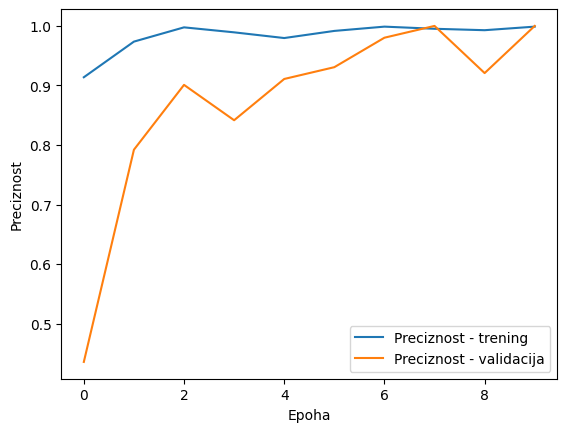

In [32]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Definisanje EarlyStopping callback-a
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Treniranje modela sa EarlyStopping callback-om
history = model.fit(train_ds,validation_data=val_ds, epochs=10, callbacks=[early_stopping])

# Prikazivanje grafika tačnosti
plt.plot(history.history['accuracy'], label='Preciznost - trening')
plt.plot(history.history['val_accuracy'], label='Preciznost - validacija')
plt.xlabel('Epoha')
plt.ylabel('Preciznost')
plt.legend()
plt.show()



### Upotreba modela u klasifikaciji planeta

8/8 [==============================] - 2s 251ms/step


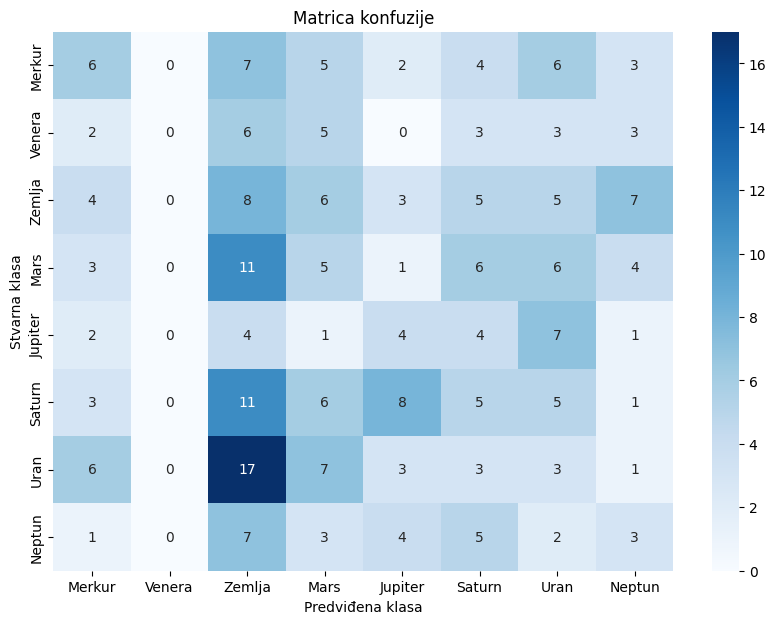

8/8 [==============================] - 2s 267ms/step - loss: 1.4250 - accuracy: 0.8789
Test accuracy: 0.87890625
Test loss: 1.4250001907348633


In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

# Predviđanja modela za test skup
predictions = np.argmax(model.predict(test_ds), axis=-1)

# Stvarne vrednosti za test skup
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Izračunavanje matrice konfuzije
conf_matrix = confusion_matrix(true_labels, predictions)

# Definisanje imena klasa
class_names = ['Merkur', 'Venera', 'Zemlja', 'Mars', 'Jupiter', 'Saturn', 'Uran', 'Neptun']

# Kreiranje DataFrame-a za matricu konfuzije
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Prikaz matrice konfuzije 
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predviđena klasa')
plt.ylabel('Stvarna klasa')
plt.title('Matrica konfuzije')
plt.show()


# Evaluacija modela na test skupu
loss, accuracy = model.evaluate(test_ds)
print("Test accuracy:", accuracy)
print("Test loss:", loss)

1/1 [==============================] - 0s 29ms/step


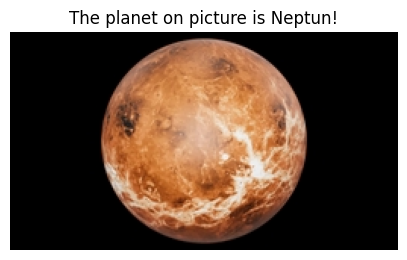

1/1 [==============================] - 0s 23ms/step


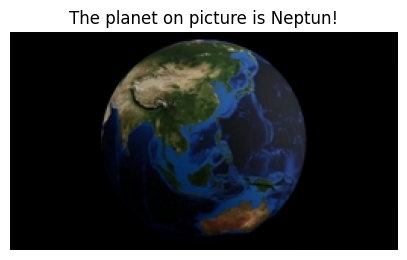

1/1 [==============================] - 0s 23ms/step


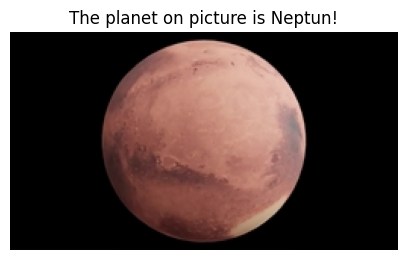

1/1 [==============================] - 0s 26ms/step


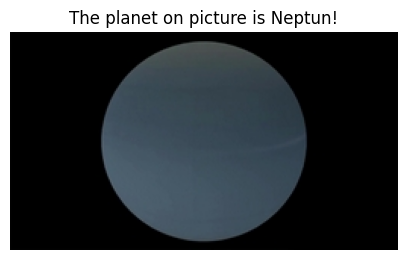

1/1 [==============================] - 0s 26ms/step


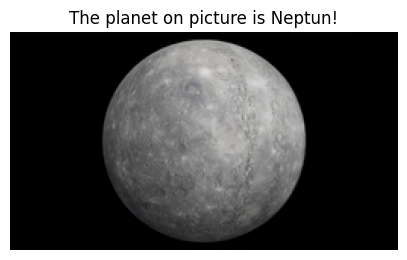

In [31]:
from tensorflow.keras.preprocessing import image
# Get a random sample of 5 images from the original dataset
random_planets = random.sample(os.listdir(data_dir), 5)

for planet in random_planets:

    random_image = random.sample(os.listdir( os.path.join(data_dir, planet) ), 1)
    
    # Load the image
    img_path = os.path.join(data_dir, planet, random_image[0])
    img = image.load_img(img_path, target_size=(256,256))
    img_array = image.img_to_array(img)

    # Preprocess the image (resize and normalize) and make a prediction
    prediction = model.predict(img_input)
    predicted_class = planete[np.argmax(prediction)]

    # Display the image and the predicted class
    plt.figure(figsize=(5, 6))
    real_img = image.load_img(img_path)
    plt.imshow(real_img)
    plt.axis('off')
    plt.title(f"The planet on picture is {predicted_class}!")
    plt.show()
